In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import characterization_loader as loader
%matplotlib inline

In [2]:
raw_data = loader.load_dataframe()
len(raw_data)

221615

In [3]:
from collections import Counter
files_per_dataset = Counter(raw_data.groupby(['Comment', 'QSinK7']).File.max())
files_per_dataset

Counter({3: 11,
         4: 1,
         5: 26,
         6: 9,
         7: 16,
         8: 5,
         9: 7,
         10: 1,
         12: 1,
         15: 1,
         19: 1})

In [4]:
sum(files_per_dataset)

98

In [5]:
mean_width = raw_data.pivot_table('width', index='QSinK7', columns='SpecMag', aggfunc=np.mean).fillna('')
mean_width

SpecMag,100.0,125.0,163.0,200.0,250.0,315.0
QSinK7,,,,,,
-42.0,792.793,,,,,
-40.0,,675.115,,,,
-36.0,449.309,,,,,
-35.0,,595.708,,,,
-32.0,,548.506,,,,
-30.0,496.7,522.418,,,1008.98,
-27.0,588.087,,,,,
-26.0,,455.52,544.911,,,
-25.0,,444.96,,,,


Dies dient als Spickzettel, damit ich weiß, wie die einzelnen Spalten exakt geschrieben werden:

In [6]:
raw_data.columns

Index(['y-position', 'y-error', 'x-position', 'x-error', 'left-position',
       'left-error', 'right-position', 'right-error', 'width', 'width-error',
       'threshold', 'fitted-x-position', 'fitted-left-position',
       'fitted-right-position', 'File', 'SpecMag', 'QSinK7', 'Comment',
       'File_Count', 'Threshold', 'Step_Size', 'Left_Offset', 'Right_Offset',
       'Polynomial_Order'],
      dtype='object')

In [7]:
def get_data(sm, filter_list={'Threshold': 'Li'}, zlp=False):
    data_filtered = raw_data[raw_data['SpecMag'] == sm]
    for key, value in filter_list.items():
        data_filtered = data_filtered[data_filtered[key] == value]
    if not zlp:
        data_filtered = data_filtered[data_filtered['Comment'].str.find('ZLP') == -1]
    data_grouped = data_filtered[['x-position',
                                  'Comment',
                                  'File',
                                  'width',
                                  'QSinK7'
                                 ]].groupby(['QSinK7', 'Comment', 'File']).mean()
    data_grouped['x-error'] = data_filtered[['x-position',
                                             'Comment',
                                             'File',
                                             'width',
                                             'QSinK7'
                                            ]].groupby(['QSinK7', 'Comment', 'File']).std()['x-position']
    data_grouped['y-error'] = data_filtered[['x-position',
                                             'Comment',
                                             'File',
                                             'width',
                                             'QSinK7'
                                            ]].groupby(['QSinK7', 'Comment', 'File']).std()['width']
    return data_grouped

def plot_width_vs_pos(dataframe):
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    cmap = cm = plt.get_cmap('Dark2')
    # Die Colormap benötigt so viele Stufen, wie es unterschiedliche QSinK7-Werte im Datensatz gibt.
    cNorm  = colors.Normalize(vmin=0, vmax=len(dataframe.groupby(level='QSinK7'))-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    index = 0

    plt.figure(figsize=(5, 9))
    # Mit Hilfe der Methode groupby() kann man über die Multiindizes iterieren.
    # Es können auch mehrere Indizes als Liste an den Parameter 'level' übergebenwerden.
    for sm, data in dataframe.groupby(level='QSinK7'):
        color = scalarMap.to_rgba(index)
        weight = np.sqrt((1 / data['x-position'])**2 + (1 / data['width'])**2)
        poly_params = np.polyfit(x=data['x-position'], y=data['width'], deg=2, w=weight)
        x_fit = np.linspace(0, 4097, 1000)
        y_fit = np.polyval(x=x_fit, p=poly_params)
        # Für das Label wird QSinK7 in ein int umgewandelt, da so die unnötige Nachkommastelle verschwindet.
        plt.plot(x_fit, y_fit, label='{} %'.format(int(sm),), c=color)
        # Damit die Datenpunkte nicht so dominant wirken wird Tranzparanz (alpha) verwendet.
        # Durch ls='none' werden die Linien entfernt, welche die Datenpunkte ansonsten verbinden.
        # Wird das Label of None (Alternative: leerere String '') gesetzt, erscheint es nicht in der Legende.
        plt.errorbar(x=data['x-position'], y=data['width'], xerr=data['x-error'], yerr=data['y-error'], alpha=0.25,
                     ls='none', label=None, c=color)
        index += 1

    plt.xlim(0, 4096)
    plt.xticks(np.arange(0, 4097, 512))
    plt.xlabel('Position des Spektrums auf der lateralen Achse [px]')
    plt.ylim(0, dataframe.width.max() * 1.1)
    plt.ylabel('Mittlere Breite des Spektrums [px]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='QSinK7')
    return plt.gcf()

def plot_width_vs_qsink7(dataframe):
    from sklearn.metrics import r2_score
    width = dataframe.groupby(level='QSinK7').mean().width
    width_fit = width[width.index <= 0]
    width_stdv = dataframe.groupby(level='QSinK7').std().width * 2
    params_line = np.polyfit(x=width_fit.index, y=width_fit, deg=1)
    def g(x):
        return np.polyval(params_line, x)
    x_low = width.index.min() - 5
    x_high = width.index.max() + 5
    x_fit = np.linspace(x_low, x_high, 100)
    y_fit = g(x_fit)
    r2 = r2_score(width_fit, g(width_fit.index))
    print('r² für den linearen Fit: %g' % (r2,))
    plt.figure(figsize=(6, 3))
    plt.errorbar(x=width.index, y=width, yerr=width_stdv, fmt='.')
    plt.plot(x_fit, y_fit)
    plt.xlim(x_low, x_high)
    plt.xlabel('QSinK7 [%]')
    _, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.ylabel('Mittlere Breite des Spektrums [px]')
    return plt.gcf()

## SpecMag 125
Es werden die Daten extrahiert, die bei SpecMag 125 aufgenommen wurden. Außerdem werden nur die Werte verwendet, die mit der Thresholding-Methode 'Li' ermittelt wurden.

Als zweites wird ein Datensatz erzeugt, der nur noch die relevanten Spalten enthält. Gleichzeitig werden alle Spalten bis auf 'QSinK7', 'Comment' und 'File' auf ihre Mittelwerte reduziert.

Zuletzt werden noch neue Spalten ergänzt, die aus der Standardabweichung der x-Position, sowie der Breite berechnete Unsicherheiten enthalten.

In [8]:
data_SM125 = get_data(sm=125)
len(data_SM125)

292

### Plotten
Das Diagramm soll die Breite der Spektren in Abhängigkeit vom QSinK7-Wert zeigen, wobei die Veränderung der Breite in Abhängigkeit von der x-Position dargestellt wird.

Da die einzelnen Werte relativ stark schwanken, wird ein Polynom 2ten Grades an die Daten angefittet. Zusätzlich sind jedoch noch die einzelnen Datenpunkte mit ihren Unsicherheiten zu sehen.

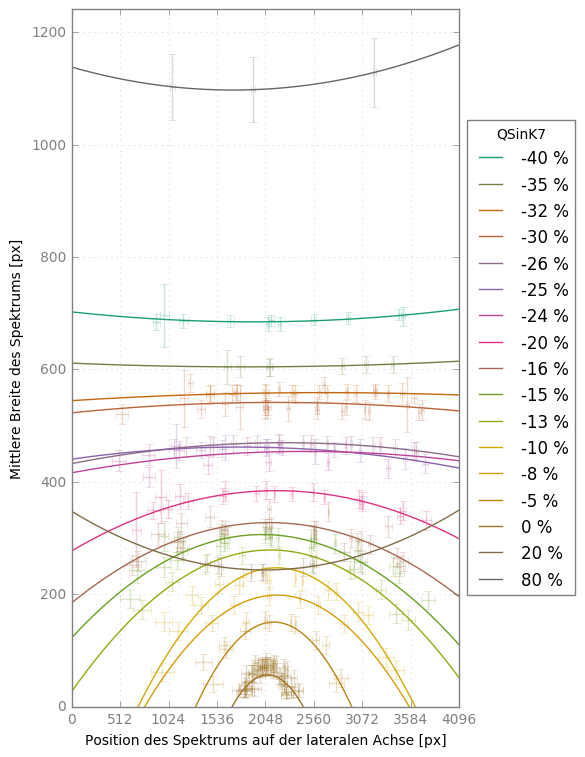

In [9]:
fig_width_vs_pos_SM125 = plot_width_vs_pos(data_SM125)
fig_width_vs_pos_SM125.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM125_width-vs-pos.pdf')

r² für den linearen Fit: 0.996047


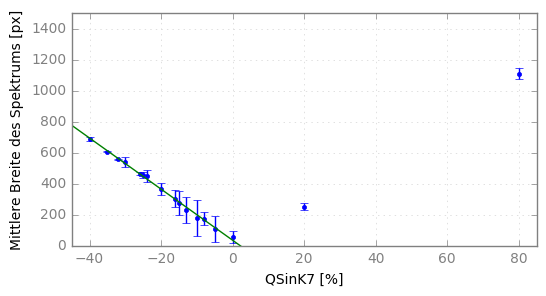

In [10]:
fig_width_vs_qsink7_SM125 = plot_width_vs_qsink7(data_SM125)
fig_width_vs_qsink7_SM125.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM125_width-vs-QSinK7.pdf')

## SpecMag 315

In [11]:
data_SM315 = get_data(sm=315)
len(data_SM315)

41

### Plotten

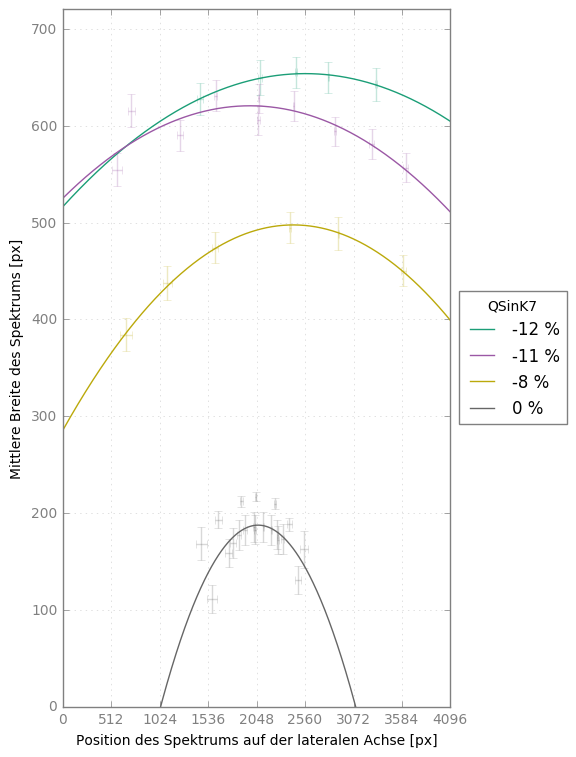

In [12]:
fig_width_vs_pos_SM315 = plot_width_vs_pos(data_SM315)
fig_width_vs_pos_SM315.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM315_width-vs-pos.pdf')

r² für den linearen Fit: 0.994184


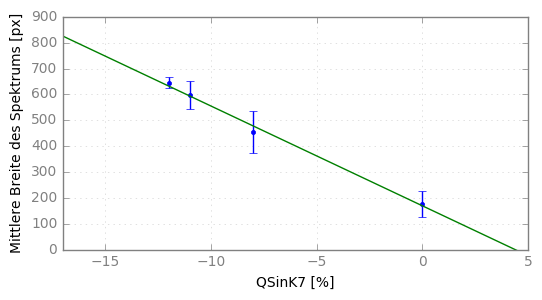

In [13]:
fig_width_vs_qsink7_SM315 = plot_width_vs_qsink7(data_SM315)
fig_width_vs_qsink7_SM315.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM315_width-vs-QSinK7.pdf')

## SpecMag 100

In [14]:
data_SM100 = get_data(sm=100)
len(data_SM100)

22

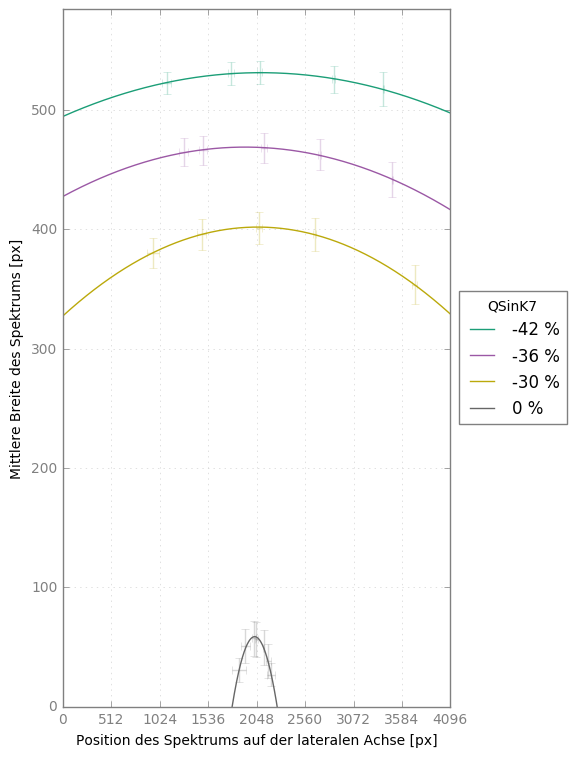

In [15]:
fig_width_vs_pos_SM100 = plot_width_vs_pos(data_SM100)
fig_width_vs_pos_SM100.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM100_width-vs-pos.pdf')

r² für den linearen Fit: 0.999851


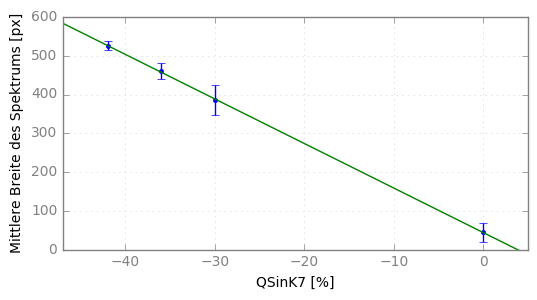

In [16]:
fig_width_vs_qsink7_SM100 = plot_width_vs_qsink7(data_SM100)
fig_width_vs_qsink7_SM100.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM100_width-vs-QSinK7.pdf')

## SpecMag 163

In [17]:
data_SM163 = get_data(sm=163)
len(data_SM163)

33

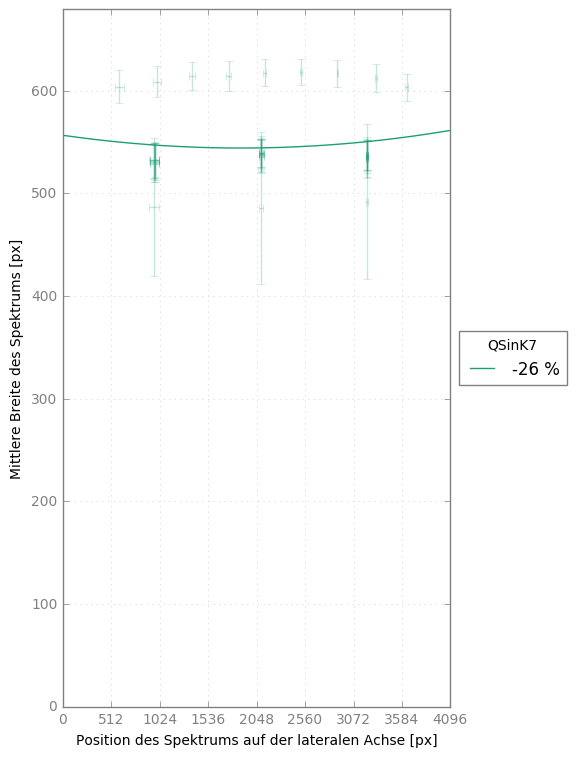

In [18]:
fig_width_vs_pos_SM163 = plot_width_vs_pos(data_SM163)

/home/michael/git/my_jupyter/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


r² für den linearen Fit: 0


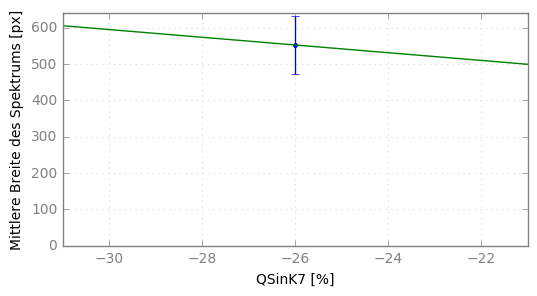

In [19]:
fig_width_vs_qsink7_SM163 = plot_width_vs_qsink7(data_SM163)

## SpecMag 200

In [20]:
data_SM200 = get_data(sm=200, zlp=True)
len(data_SM200)

70

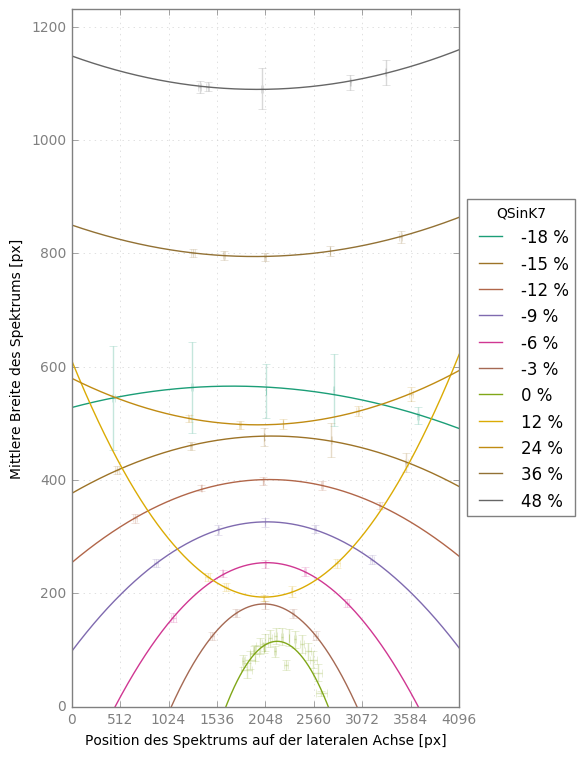

In [21]:
fig_width_vs_pos_SM200 = plot_width_vs_pos(data_SM200)
fig_width_vs_pos_SM200.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM200_width-vs-pos.pdf')

r² für den linearen Fit: 0.993554


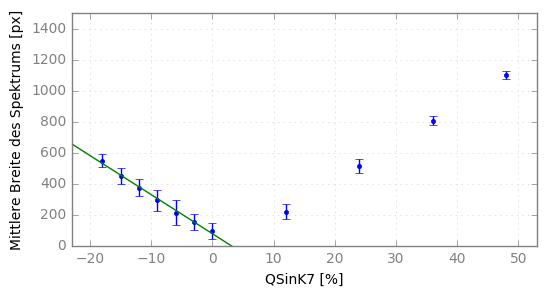

In [22]:
fig_width_vs_qsink7_SM200 = plot_width_vs_qsink7(data_SM200)
fig_width_vs_qsink7_SM200.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_SM200_width-vs-QSinK7.pdf')

## SpecMag 250

In [23]:
data_SM250 = get_data(sm=250)
len(data_SM250)

12

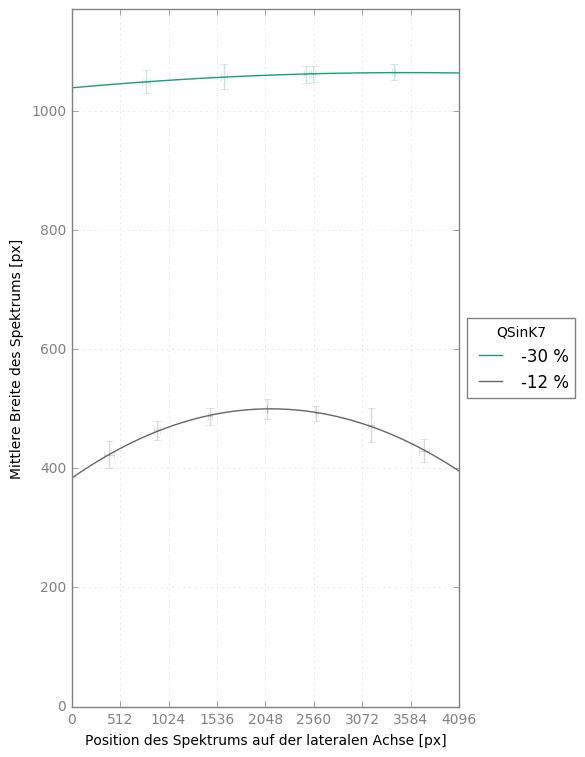

In [24]:
fig_width_vs_pos_SM250 = plot_width_vs_pos(data_SM250)

r² für den linearen Fit: 1


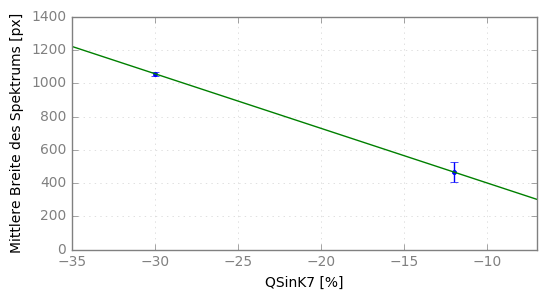

In [25]:
fig_width_vs_qsink7_SM250 = plot_width_vs_qsink7(data_SM250)

## Vergleich von SM125 und SM315

In [26]:
data_SM125_m30 = data_SM125.loc[-30.0]
data_SM315_m8 = data_SM315.loc[-8.0]

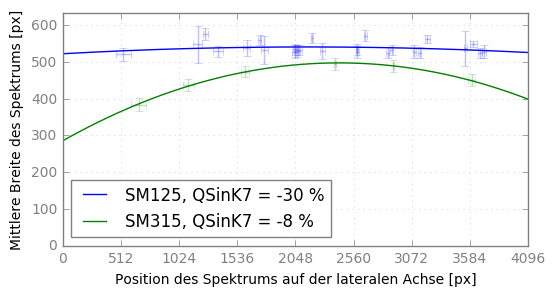

In [27]:
plt.figure(figsize=(6, 3))
weight_SM125 = np.sqrt((1 / data_SM125_m30['x-position'])**2 + (1 / data_SM125_m30['width'])**2)
weight_SM315 = np.sqrt((1 / data_SM315_m8['x-position'])**2 + (1 / data_SM315_m8['width'])**2)
poly_params_SM125 = np.polyfit(x=data_SM125_m30['x-position'], y=data_SM125_m30['width'], deg=2, w=weight_SM125)
poly_params_SM315 = np.polyfit(x=data_SM315_m8['x-position'], y=data_SM315_m8['width'], deg=2, w=weight_SM315)
x_fit = np.linspace(0, 4097, 1000)
y_fit_SM125 = np.polyval(x=x_fit, p=poly_params_SM125)
y_fit_SM315 = np.polyval(x=x_fit, p=poly_params_SM315)
plt.plot(x_fit, y_fit_SM125, label='SM125, QSinK7 = -30 %', c='b')
plt.plot(x_fit, y_fit_SM315, label='SM315, QSinK7 = -8 %', c='g')
plt.errorbar(x=data_SM125_m30['x-position'], y=data_SM125_m30['width'], 
             xerr=data_SM125_m30['x-error'], yerr=data_SM125_m30['y-error'],
             alpha=0.25, ls='none', label=None, c='b'
            )
plt.errorbar(x=data_SM315_m8['x-position'], y=data_SM315_m8['width'],
             xerr=data_SM315_m8['x-error'], yerr=data_SM315_m8['y-error'],
             alpha=0.25, ls='none', label=None, c='g'
            )


plt.xlim(0, 4096)
plt.xticks(np.arange(0, 4097, 512))
plt.xlabel('Position des Spektrums auf der lateralen Achse [px]')
plt.ylim(0, max(data_SM125_m30.width.max(), data_SM315_m8.width.max()) * 1.1)
plt.ylabel('Mittlere Breite des Spektrums [px]')
plt.legend(loc='best')
plt.savefig('/home/michael/git/Dissertation/LaTeX_main/Bilder/QSinK7_Vergleich_SM125_SM315.pdf')

## Vergrößerung bei SM125 mit QSinK7 = -32%

In [28]:
data_SM125.loc[0.0].width.max()

80.506666666666661

In [29]:
data_SM125.loc[-32.0].width.max()

560.59000000000003

In [30]:
data_SM125.loc[-32.0].width.max() / data_SM125.loc[0.0].width.max()

6.9632742630009945